In [3]:
import os
import torch


from terratorch import BACKBONE_REGISTRY

In [5]:
!pip install gdal

In [2]:
!pip install terratorch

In [6]:
!pip install torchgeo>=0.6.0

In [70]:
!pip install git+https://github.com/IBM/terratorch.git


  Cloning https://github.com/IBM/terratorch.git to /tmp/pip-req-build-ppko438s
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-ppko438s
  Resolved https://github.com/IBM/terratorch.git to commit 97a2f61c89b01091c53ef3f2c2207a1a6900750f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Check out the quick start in the docs for more details.

# Backbone factory

In [7]:
print([model_name for model_name in BACKBONE_REGISTRY if "prithvi" in model_name])

['timm_prithvi_eo_v2_300', 'timm_prithvi_eo_v2_300_tl', 'timm_prithvi_eo_v2_600', 'timm_prithvi_eo_v2_600_tl', 'timm_prithvi_swin_B', 'timm_prithvi_swin_L', 'timm_prithvi_vit_100', 'timm_prithvi_vit_tiny']


In [131]:
"prithvi_eo_v1_100" in BACKBONE_REGISTRY

True

In [73]:
"prithvi_vit_100" in BACKBONE_REGISTRY

True

In [8]:
model = BACKBONE_REGISTRY.build("timm_prithvi_eo_v2_300")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

## The model
The resulting model is a torch module, but only the encoder (backbone) portion.

In this case, it comes from the underlying timm registry, and is wrapped in a `TimmBackboneWrapper`.

By default, the model is instantiated with the same bands it was pretrained on, with the same order.

We can inspect both of these.

In [10]:
print(f"The model was pretrained on bands {model._timm_module.pretrained_bands}.\n The model is using bands {model._timm_module.model_bands}")

The model was pretrained on bands [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].
 The model is using bands [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]


The model output is a list with the output of each encoder stage. This may be different for each encoder.

In [9]:
trial_data = torch.zeros(1, 6, 224, 224) # batch_size, channels, height, width
features = model(trial_data)
for index, feature in enumerate(features):
    print(f"Feature index {index} has shape {feature.shape}")

Feature index 0 has shape torch.Size([1, 197, 1024])
Feature index 1 has shape torch.Size([1, 197, 1024])
Feature index 2 has shape torch.Size([1, 197, 1024])
Feature index 3 has shape torch.Size([1, 197, 1024])
Feature index 4 has shape torch.Size([1, 197, 1024])
Feature index 5 has shape torch.Size([1, 197, 1024])
Feature index 6 has shape torch.Size([1, 197, 1024])
Feature index 7 has shape torch.Size([1, 197, 1024])
Feature index 8 has shape torch.Size([1, 197, 1024])
Feature index 9 has shape torch.Size([1, 197, 1024])
Feature index 10 has shape torch.Size([1, 197, 1024])
Feature index 11 has shape torch.Size([1, 197, 1024])
Feature index 12 has shape torch.Size([1, 197, 1024])
Feature index 13 has shape torch.Size([1, 197, 1024])
Feature index 14 has shape torch.Size([1, 197, 1024])
Feature index 15 has shape torch.Size([1, 197, 1024])
Feature index 16 has shape torch.Size([1, 197, 1024])
Feature index 17 has shape torch.Size([1, 197, 1024])
Feature index 18 has shape torch.Size(

## Band choice
Sometimes you may wish to use a separate set of bands than was used in pretraining. This may be a different ordering, a subset, a superset, or a completely different set.

To do this, you may specify the bands you wish to train on using a mixture of integers and members of the `HLSBands` enum.

In the patch embed layer, the weights corresponding to bands that exist in the pretrained bands will be mapped to the correct order. Bands that do not exist will be randomly initialized.

In [12]:
 0.018
      - 0.14
      - 0.076
      - 0.11
      - 0.65

In [11]:
from terratorch.datasets import HLSBands

# lets get only the RGB bands, and put them in that order rather than BGR, and lets add an extra band not in HLSBands
bands = [HLSBands.RED, HLSBands.GREEN, HLSBands.BLUE, 14]
model = BACKBONE_REGISTRY.build( # let's use a vit model this time
    "prithvi_vit_100", num_frames=1, pretrained=True, bands=bands )


config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

Prithvi_EO_V1_100M.pt:   0%|          | 0.00/454M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


In [12]:
# the model now expects 4 channels, not 6
trial_data = torch.zeros(1, 4, 224, 224) # batch_size, channels, height, width
features = model(trial_data)
for index, feature in enumerate(features):
    print(f"Feature index {index} has shape {feature.shape}")

Feature index 0 has shape torch.Size([1, 197, 768])
Feature index 1 has shape torch.Size([1, 197, 768])
Feature index 2 has shape torch.Size([1, 197, 768])
Feature index 3 has shape torch.Size([1, 197, 768])
Feature index 4 has shape torch.Size([1, 197, 768])
Feature index 5 has shape torch.Size([1, 197, 768])
Feature index 6 has shape torch.Size([1, 197, 768])
Feature index 7 has shape torch.Size([1, 197, 768])
Feature index 8 has shape torch.Size([1, 197, 768])
Feature index 9 has shape torch.Size([1, 197, 768])
Feature index 10 has shape torch.Size([1, 197, 768])
Feature index 11 has shape torch.Size([1, 197, 768])


# Model factory
The model factories let us create full models ready for specific tasks, including decoders and task specific heads.
They create normal `torch.nn.Module` s that you can use anywhere in your code.

Lets create a model for semantic segmentation with 4 classes

In [14]:
from terratorch.models import EncoderDecoderFactory

model_factory = EncoderDecoderFactory()

# Let's build a segmentation model
# Parameters prefixed with backbone_ get passed to the backbone
# Parameters prefixed with decoder_ get passed to the decoder
# Parameters prefixed with head_ get passed to the head

model = model_factory.build_model(task="segmentation",
        backbone="prithvi_vit_100",
        decoder="FCNDecoder",
        backbone_bands=[
            HLSBands.BLUE,
            HLSBands.GREEN,
            HLSBands.RED,
            HLSBands.NIR_NARROW,
            HLSBands.SWIR_1,
            HLSBands.SWIR_2,
        ],
        num_classes=5,
        backbone_pretrained=True,
        backbone_num_frames=1,
        decoder_channels=128,
        head_dropout=0.2
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PixelWiseModel(
  (encoder): TimmBackboneWrapper(
    (_timm_module): PrithviViT(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
       

Their output is a `ModelOutput` object, including the main `output` and the output of any `auxiliary_heads`.

In [51]:
trial_data = torch.zeros(1, 6, 224, 224) # batch_size, channels, height, width
out = model(trial_data)
print(out.output.shape)

torch.Size([1, 5, 224, 224])


# Datamodule
You can create datamodules for training by creating your own subclasses of `torchgeo.datamodules.GeoDataModule` or `torchgeo.datamodules.NonGeoDataModule`.

Alternatively, leverage one of our generic data modules.

Datamodules package train, test and validation datasets as well as any transforms done.

Any [TorchGeo](https://torchgeo.readthedocs.io/en/stable/) datamodule will also be compatible with TerraTorch.

## Toy example

Let's set up a toy example for burn scar segmentation.

You can get the full dataset at https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars.

For this example, we will use a single image which we will download from the demo.



In [13]:
# cd to the notebooks dir if not there
%cd examples/notebooks/

[Errno 2] No such file or directory: 'examples/notebooks/'
/content


In [14]:
# download the image
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif

input_file_name = "subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif"
label_file_name = "subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4.mask.tif"

--2024-12-09 09:08:43--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.88, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/1c/09/1c0948cc618defc1284e350591d02a434dcb4e42e8be4eb411c4ccbaae569c03/4680447af6e80df15616c5148a7d004d9c958905c082ea51b16c2e9e4ab29d85?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif%3B+filename%3D%22subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif%22%3B&response-content-type=image%2Ftiff&Expires=1733994523&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzk5NDUyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xYy8wOS8xYzA5NDhj

In [15]:
# Assuming your file is uploaded to the root directory in Colab
!unzip -q burn_intensity_data.zip -d /content/burn_intensity_dataset


In [16]:
# organize the data directory
import shutil
import matplotlib.pyplot as plt
import rioxarray as rio

#if not os.path.isdir("/content/burn_scar_segmentation_toy"):
source_dir = "/content/burn_intensity_dataset/burn_intensity_data"
if not os.path.isdir(source_dir):

    os.mkdir(source_dir)

    for data_dir in ["train_images", "test_images", "validation_images"]:
        os.mkdir(os.path.join(source_dir, data_dir))
        shutil.copy(input_file_name, os.path.join(source_dir, data_dir, input_file_name))

    for label_dir in ["train_labels", "test_labels", "validation_labels"]:
        os.mkdir(os.path.join(source_dir, label_dir))
        shutil.copy(label_file_name, os.path.join(source_dir, label_dir, label_file_name))



In [39]:
import os

# Specify the directory path
train_image_folder= "/content/burn_intensity_dataset/burn_intensity_data/train_images"
train_label_folder= "/content/burn_intensity_dataset/burn_intensity_data/train_labels"


val_image_folder= "/content/burn_intensity_dataset/burn_intensity_data/validation_images"
val_label_folder= "/content/burn_intensity_dataset/burn_intensity_data/validation_labels"

test_image_folder= "/content/burn_intensity_dataset/burn_intensity_data/test_images"
test_label_folder= "/content/burn_intensity_dataset/burn_intensity_data/test_labels"


# Get the full file path of the first file
files_image = sorted([f for f in os.listdir(train_image_folder) if os.path.isfile(os.path.join(train_image_folder, f))])
if files_image:
    first_file = files_image[1]  # Get the first file
    first_image_path = os.path.join(train_image_folder, first_file)  # Full path to the file
    print(f"First file: {first_file}")
    print(f"Full path: {first_image_path}")
else:
    print("The directory is empty.")

files_label = sorted([f for f in os.listdir(train_label_folder) if os.path.isfile(os.path.join(train_label_folder, f))])
if files_label:
    first_file = files_label[1]  # Get the first file
    first_label_path = os.path.join(train_label_folder, first_file)  # Full path to the file
    print(f"First file: {first_file}")
    print(f"Full path: {first_label_path}")
else:
    print("The directory is empty.")


file_image_path = os.path.join(train_image_folder, first_image_path)
file_label_path = os.path.join(train_label_folder, first_label_path)
print(file_image_path)
print(file_label_path)

# if file_name:
#     file_path = os.path.join(source_dir, file_name)  # Create the full file path
#     print(f"First file path: {file_path}")
# else:
#     print("The directory is empty.")


First file: az3455711116020180427_0224_0000_HLS.tiff
Full path: /content/burn_intensity_dataset/burn_intensity_data/train_images/az3455711116020180427_0224_0000_HLS.tiff
First file: az3455711116020180427_0224_0000_BS.tiff
Full path: /content/burn_intensity_dataset/burn_intensity_data/train_labels/az3455711116020180427_0224_0000_BS.tiff
/content/burn_intensity_dataset/burn_intensity_data/train_images/az3455711116020180427_0224_0000_HLS.tiff
/content/burn_intensity_dataset/burn_intensity_data/train_labels/az3455711116020180427_0224_0000_BS.tiff


## Let's visualize the data

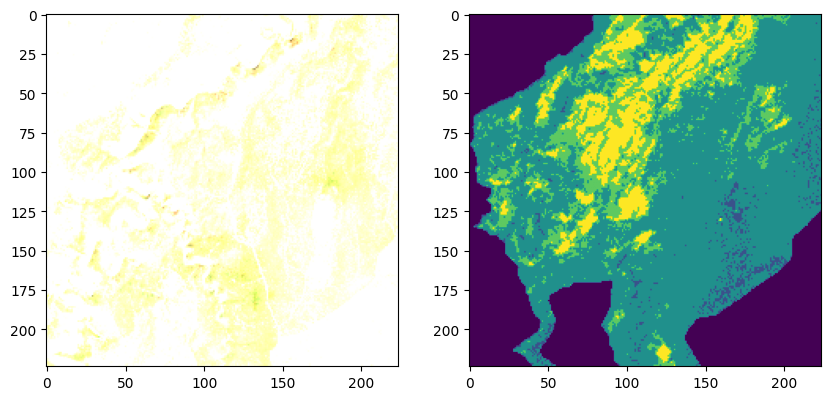

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(rio.open_rasterio(file_image_path).sel(band=[3, 2, 1]).transpose("y", "x", "band").to_numpy())

ax[1].imshow(rio.open_rasterio(file_label_path).to_numpy()[0])

In [82]:
tensor = rio.open_rasterio(file_label_path).to_numpy()
print(tensor.shape)

import numpy as np
np.unique(tensor)

(1, 224, 224)


array([0., 1., 2., 3., 4.])

In [45]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

batch_size = 4
num_workers = 0
train_val_test = [
    train_image_folder,
    val_image_folder,
    test_image_folder
]

train_val_test_labels = {
    "train_label_data_root": train_label_folder,
    "val_label_data_root": val_label_folder,
    "test_label_data_root": test_label_folder,
}

# from https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/configs/burn_scars.py
means=[
        0.033349706741586264,
        0.05701185520536176,
        0.05889748132001316,
        0.2323245113436119,
        0.1972854853760658,
        0.11944914225186566,
    ]
stds=[
        0.02269135568823774,
        0.026807560223070237,
        0.04004109844362779,
        0.07791732423672691,
        0.08708738838140137,
        0.07241979477437814,
    ]
datamodule = GenericNonGeoSegmentationDataModule(
    batch_size,
    num_workers,
    *train_val_test,
    "*_HLS.tiff", # img grep
    "*_BS.tiff", # label grep
    means,
    stds,
    5, # num classes
    **train_val_test_labels,

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transform,
    # val_transform=val_transform,
    # test_transform=test_transform,

    # edit the below for your usecase
    dataset_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    output_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    no_data_replace=0,
    no_label_replace=-1,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

In [46]:

from terratorch.models.model import AuxiliaryHead
from terratorch.tasks import SemanticSegmentationTask

epochs = 1 # 1 epoch for demo
lr = 1e-3
model_args = {
        "backbone":"prithvi_vit_100",
        "decoder":"FCNDecoder",
        "num_classes": 5,

        "backbone_bands": [
            HLSBands.RED,
            HLSBands.GREEN,
            HLSBands.BLUE,
            HLSBands.NIR_NARROW,
            HLSBands.SWIR_1,
            HLSBands.SWIR_2,
        ],
        "backbone_pretrained": True,
        "backbone_num_frames":1, # this is the default
        "decoder_channels":128,
        "head_dropout":0.2,
        "necks": [
            {"name": "SelectIndices", "indices": [-1]},
            {"name": "ReshapeTokensToImage"}
        ]
}


task = SemanticSegmentationTask(
    model_args,
    "EncoderDecoderFactory",
    loss="ce",
    aux_loss={"fcn_aux_head": 0.4},
    lr=lr,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=False,

    class_names=['No burn', 'Unburned to Very Low', 'Low Severity', 'Moderate Severity','High Severity'],
    class_weights=[0.01, 0.1, 0.19, 0.2, 0.5]

)

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


# Lightning Trainers
At the highest level of abstraction, you can operate with task specific trainers. These encapsulate the model, loss, optimizer and any training hyperparameters.

They build on the model factory we introduced previously and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer for Semantic Segmentation.

Now we can use a Lightning Trainer to train this model on the datamodule we specified

In [56]:
import os

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW

accelerator = "cpu"
experiment = "tutorial"
if not os.path.isdir("tutorial_experiments"):
    os.mkdir("tutorial_experiments")
default_root_dir = os.path.join("tutorial_experiments", experiment)
checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=10)
logger = TensorBoardLogger(save_dir=default_root_dir, name=experiment)
#reduce_lr = ReduceLROnPlateau(optimizer = task,
 #                             patience=5)
trainer = Trainer(
    precision="bf16-mixed",
    accelerator=accelerator,
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
        early_stopping_callback
    ],
    logger=logger,
    max_epochs=epochs, # train only one epoch for demo
    default_root_dir=default_root_dir,
    log_every_n_steps=1,
    check_val_every_n_epoch=10,
    devices=1
)


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
trainer.fit(model=task, datamodule=datamodule)

Epoch 0/0  ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/59 0:07:21 • -:--:-- 0.00it/s v_num: 0.000

In [108]:
trainer.test(model=task, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    1.7085586786270142     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 1.7085586786270142}]

In [38]:
trainer.test(model=task, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    1.6343175172805786     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 1.6343175172805786}]

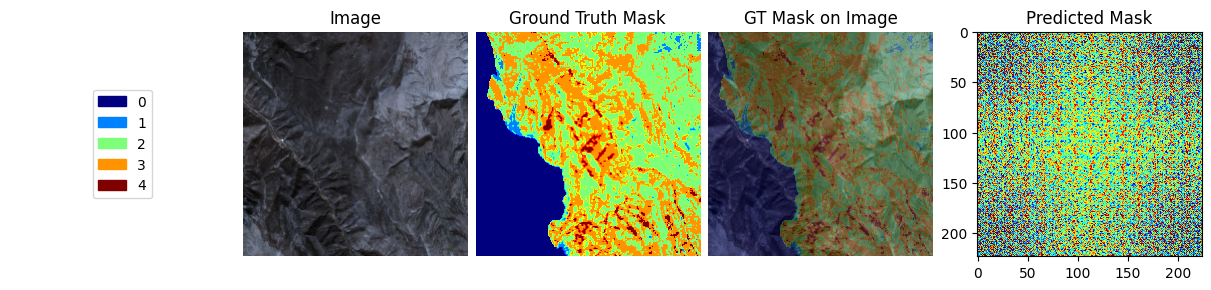

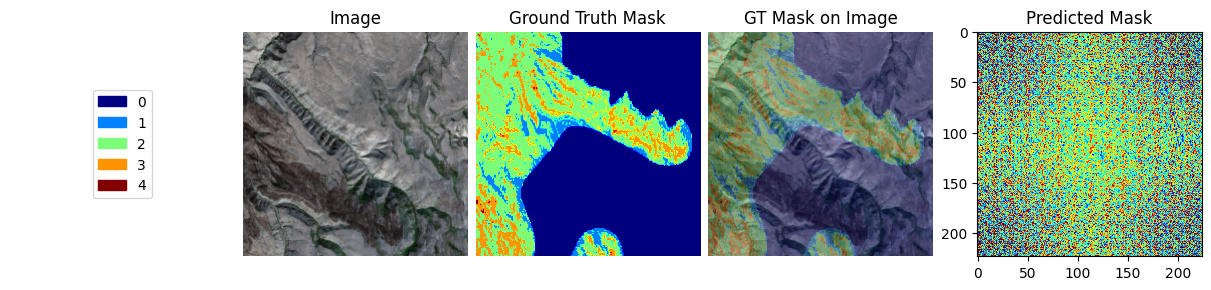

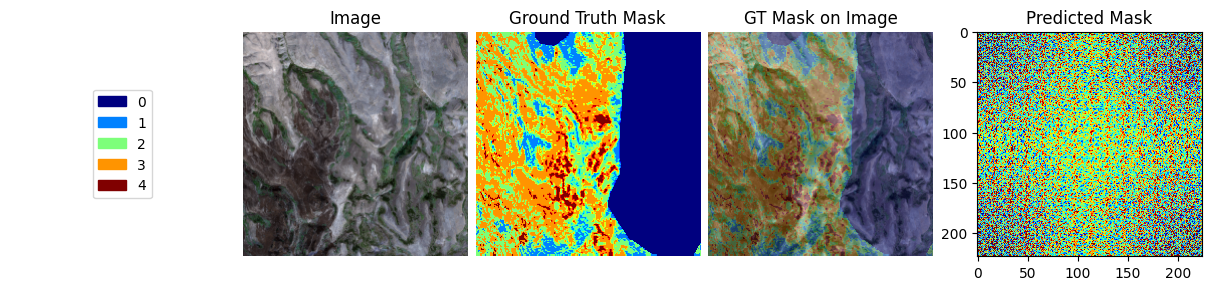

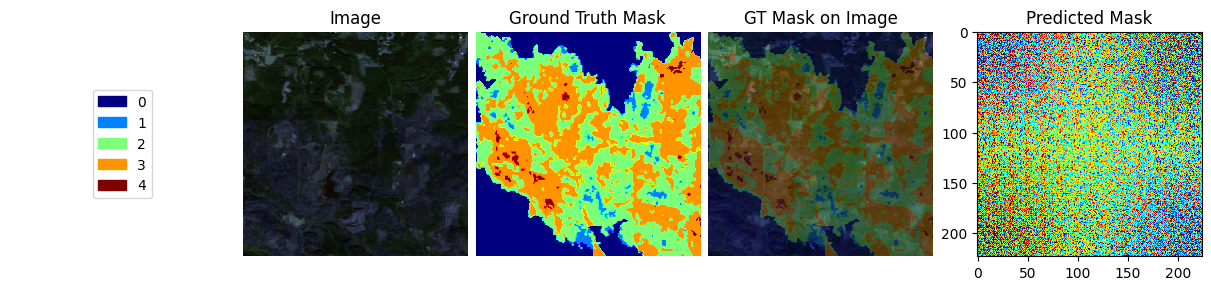

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = datamodule.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)

    masks = batch["mask"].numpy()
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(4):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset = datamodule.test_dataset
    test_dataset.plot(sample)

# Configs
Alternatively, define all this in a config file and run it through the cli. This is the reccomended approach.

Check out example config files under `examples/confs`.

```